<span style="font-size: 32px; font-weight:bold">Text Classification</span>

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize,word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

<span style="font-size: 25px; font-weight:bold">Data Preprocessing</span>

In [2]:
data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

In [3]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
len(data['data']),len(data['target'])# total documents/newsgroup in our training example

(18846, 18846)

In [5]:
len(data['target_names']) # total possible labels for the doucments/newsgroups wihich 20

20

In [6]:
X_documents =[word_tokenize(document) for document in data['data']] # X
Y_labels = data['target'] # Y

<span style="font-size: 20px; font-weight:light">training data comprises of 18846 documents and there correspomding labels as output</span>  
<span style="font-size: 20px; font-weight:light">so X_documents = training examples and Y_labels = labels corresponding to training documents</span>

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_documents, Y_labels, random_state=1)

In [8]:
stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
extra_stops_word=np.loadtxt("data/stop words english.txt",dtype=str, encoding='utf-8')
stop_words.update(punctuations)
stop_words.update(extra_stops_word)
len(stop_words)

905

In [9]:
# constructing vocabulary - contains all the words present across all training document
# thus single word can be present multiple times in the vocabulary
vocabulary =[]
for document in X_train:
    for word in document:
        if word.lower() not in stop_words and len(word)>3:
            vocabulary.append(word.lower())

In [10]:
len(vocabulary)

1686645

In [11]:
# constructing dictionary with keys as words in vocabulary and value as there count in all documents
vocabulary_dic ={}
for word in vocabulary:
    if word in vocabulary_dic.keys():
        vocabulary_dic[word]=vocabulary_dic[word]+1
    else:
        vocabulary_dic[word]=1

In [12]:
len(vocabulary_dic.keys())

188277

<span style="font-size: 20px; font-weight:light">Total unique words across all the training documents execopt the stoping words = 213449</span>

<span style="font-size: 25px; font-weight:bold">Distribution of Words (Frequency vs Word)</span>

In [13]:
unique_words = np.array([key for key in vocabulary_dic.keys()])
freq_words = np.array([value for value in vocabulary_dic.values()])

In [14]:
unique_words.shape,freq_words.shape

((188277,), (188277,))

In [15]:
unique_words=unique_words[np.argsort(freq_words)][::-1]
freq_words=np.sort(freq_words)[::-1]

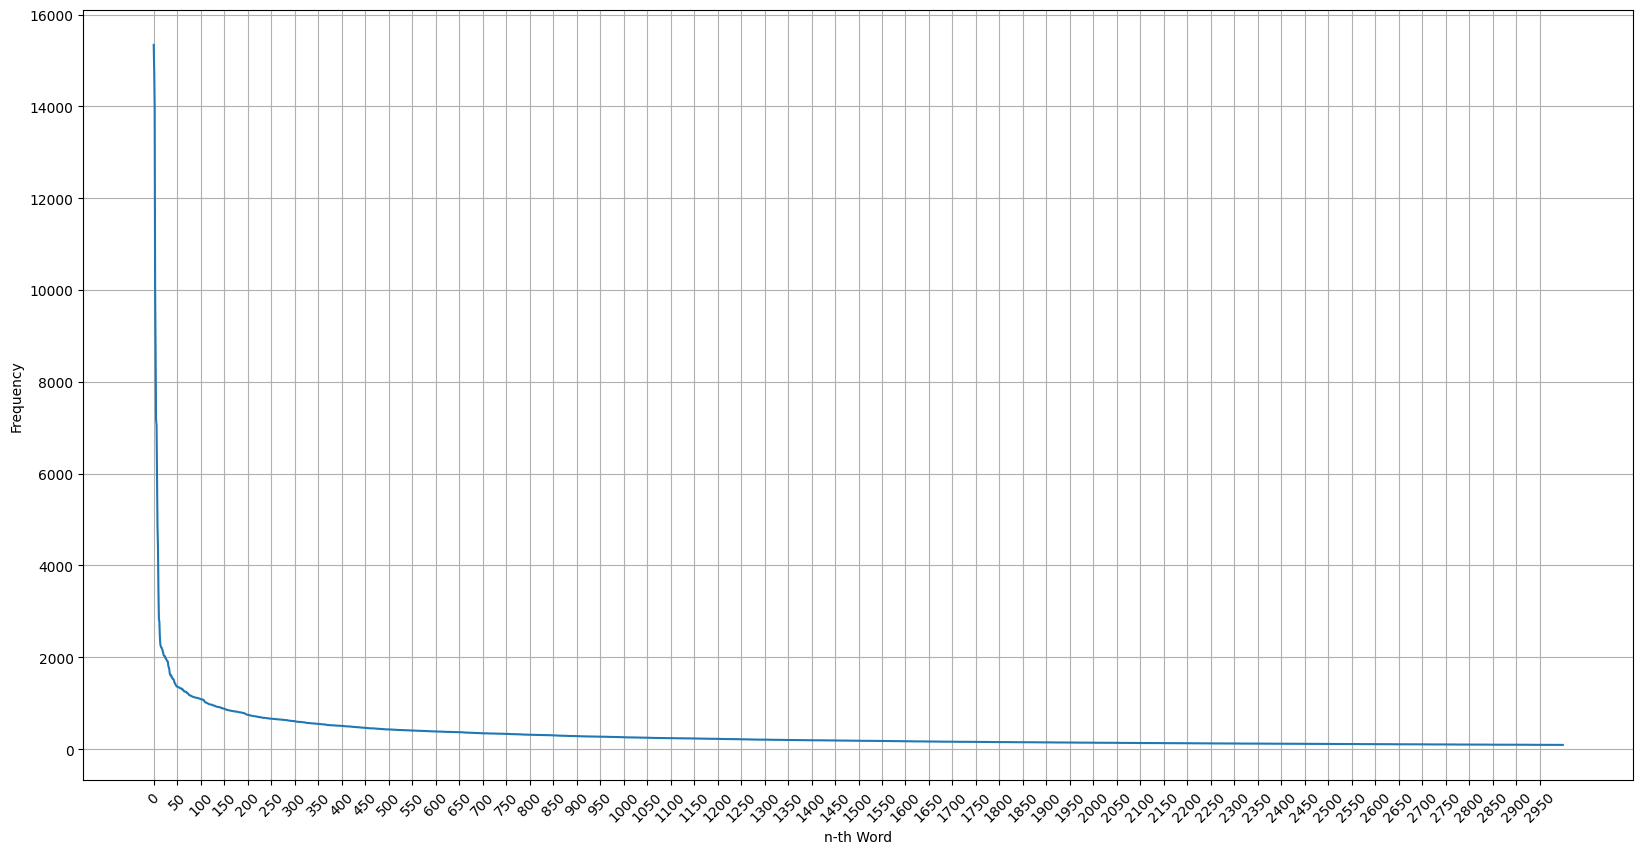

In [16]:
#plot the words vs frequency graph 
lower_limit=0 
upper_limit=3000 
difference_between_each_xtick=50  #default value. change these values to observe the graph in more depth
#adjusting size of the graph for more clearity.
plt.figure(figsize=(20, 10))
#plotting
plt.plot(np.arange(upper_limit), freq_words[lower_limit:upper_limit])
plt.xlabel('n-th Word') # x axis represents word so n-th word represt most occuring n-th word
plt.ylabel("Frequency") # y axis represent the frequency corresponding to these words
#adjusting the xticks
plt.xticks(np.arange(lower_limit, upper_limit, 50), rotation=45)
plt.grid()
plt.show()

<span style="font-size: 20px; font-weight:light">From the above graph it is evident that the count of words exponentialy decreases so it doesn't matter to consider those words which roughly present in few documents</span>  
<span style="font-size: 20px; font-weight:light">For the training purpose it's better to take more frequently words excluding the stopping words as it will have more effect on deciding whhich label to choose</span>  
<span style="font-size: 20px; font-weight:light">So in our case we are going with first 10000 words as features set or word features</span>


In [17]:
freq_words[10000]

22

In [18]:
word_features = unique_words[0:10000].tolist()

In [19]:
# the fucntion converts the given document to an array of length (word_features)
# and each index corresponds to each feature word values how much it contains in the document
def document_to_array(document,word_features):
    modified_document =np.zeros(len(word_features))
    for word in document:
        if word in word_features:
            index = word_features.index(word)
            modified_document[index]=modified_document[index]+1
    return modified_document     

In [20]:
def get_modified_data(data,word_features):
    modified_data=[]
    for document in data:
        modified_data.append(document_to_array(document,word_features))
    return modified_data

In [21]:
X_train_modified = get_modified_data(X_train,word_features)
X_test_modified = get_modified_data(X_test,word_features)

<span style="font-size: 25px; font-weight:bold">SKLearn Multinomial Naive Bayes</span>

In [ ]:
model = MultinomialNB()
model.fit(X_train_modified, Y_train)

MultinomialNB()

In [ ]:
Y_pred = model.predict(X_test_modified)

In [ ]:
accuracy = metrics.accuracy_score(Y_test, Y_pred)
accuracy

0.8064516129032258

<span style="font-size: 25px; font-weight:bold">Scratch Naive Bayes</span>

In [ ]:
X_train = np.array(X_train_modified)
Y_train = np.array(Y_train)
X_test = np.array(X_test_modified)
Y_test = np.array(Y_test)

In [ ]:
# The fit function is responsible for creating dictionary of the training data set
# dictionary indicates the count of total features words corresponding to specific class document

def fit (X_train,Y_train,feature_words):
    dictionary ={}
    dictionary['total_docs'] = Y_train.shape[0]
    possible_labels = set(Y_train)
    for label_i in possible_labels:
        # the row_label_i is an array with 'true' against those index values where the Y_train is labelled as label_i and 'false' otherwise
        rows_label_i = (Y_train == label_i)
        
        # the X_train_label_i and Y_train_label_i  only contains those rows from X_train and Y_train where rows_label_i is 'true'
        X_train_label_i = X_train[rows_label_i]
        Y_train_label_i = Y_train[rows_label_i]
        dictionary[label_i] ={}
        dictionary[label_i]['total_docs'] = Y_train_label_i.shape[0]
        total_words = 0
        
        for i in range(len(feature_words)):
            word = feature_words[i]
            total_words +=X_train_label_i[:, i].sum()
            dictionary[label_i][word] = X_train_label_i[:, i].sum()
        dictionary[label_i]['total_words'] =total_words
    return dictionary

In [ ]:
# function which return log probability that for given feature = x what is the probability that label = label_i
# using bayes theorem

def log_probability(dictionary,x,label_i,word_features,alpha=1.0):
    # probability1 = Probability of getting label_i out of all possible labels
    log_probability1 = np.log(dictionary[label_i]['total_docs']) -np.log(dictionary['total_docs'])
    
    # probability2 = Probability of document has feature words (x1,x2,,,) of x given the docuemnt class is label_i
    log_probability2=0
    total_word_train = dictionary[label_i]['total_words']
    total_word_test = np.sum(x)
    
    # probability3 = A factor lamba is being multipied with the above two result
    # lamba = total count of xi (feature of x) in 'test document' / total number of words in 'test document'
    
    for i in range(len(x)):
        if x[i] ==0:
            continue
        count_current_word_train = dictionary[label_i][word_features[i]]
        count_current_word_test = x[i]
        _lamda = np.log(count_current_word_test) - np.log(total_word_test)
        log_probability2 += np.log((count_current_word_train + alpha)) - np.log((total_word_train + alpha * len(word_features)))
        log_probability2 +=_lamda
        
    log_result = log_probability1 + log_probability2
    return log_result

In [ ]:
# The predict_pount_label function is responsible for predicitng the label for a single document
def predict_point_label(dictionary,x,word_features):
    possible_labels = dictionary.keys()
    best_probability=-1
    best_label =-1
    first_run=True
    for label_i in possible_labels:
        if label_i == 'total_docs':
            continue
        probability_label_i = log_probability(dictionary,x,label_i,word_features)
        if first_run or probability_label_i>best_probability:
            best_probability = probability_label_i
            best_label = label_i
        first_run=False
    return best_label

In [ ]:
# The predict function is responsible for predicitng the labels for the testing data
def predict (dictionary,X_test,word_features):
    Y_pred = []
    for x in X_test:
        x_label = predict_point_label(dictionary,x,word_features)
        Y_pred.append(x_label)
    return Y_pred

In [ ]:
dictionary = fit(X_train,Y_train,word_features)

In [ ]:
Y_pred = predict(dictionary,X_test,word_features)

In [ ]:
accuracy = metrics.accuracy_score(Y_test, Y_pred)
accuracy

0.807937181663837

<span style="font-size: 20px; font-weight:light">Accuracy obtained in both sklearn naive bayes classifer and the scratch built naive classifier are nearly same indicating both perfroms well </span>